In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data

from batchgenerators.dataloading.data_loader import DataLoaderBase

## Let's create a DataLoader that gives us some image. Your implementation will vary depending on your dataset. Here we just output the same image all the time.

In [2]:
class DataLoader(DataLoaderBase):
    def __init__(self, data, BATCH_SIZE=2, num_batches=None, seed=False):
        super(DataLoader, self).__init__(data, BATCH_SIZE, num_batches, seed) 
        # data is now stored in self._data.
    
    def generate_train_batch(self):
        # usually you would now select random instances of your data. We only have one therefore we skip this
        img = self._data
        
        # The camera image has only one channel. Our batch layout must be (b, c, x, y). Let's fix that
        img = np.tile(img[None, None], (self.BATCH_SIZE, 1, 1, 1))
        
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        return {'data':img.astype(np.float32), 'some_other_key':'some other value'}

## Now we can get some batches:

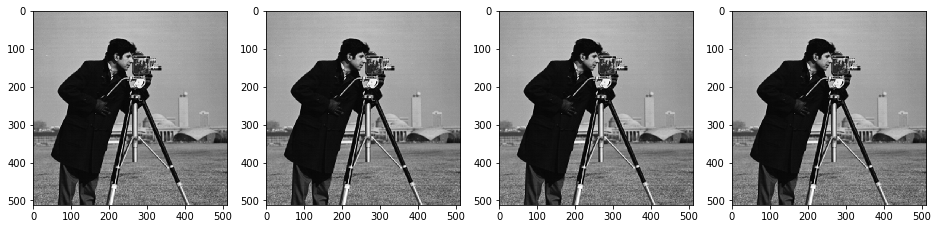

In [3]:
batchgen = DataLoader(data.camera(), 4, None, False)
batch = batchgen.next()

def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(batch['data'][i, 0], cmap="gray") # only grayscale image here
    plt.show()

plot_batch(batch)

## It's time for some transformations! 
We are not going to waste any time and do it multithreaded

In [4]:
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import Mirror
from batchgenerators.transforms.abstract_transform import Compose
from batchgenerators.transforms.multi_threaded_augmenter import MultiThreadedAugmenter

my_transforms = []
brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
my_transforms.append(brightness_transform)
mirror_transform = Mirror(axes=(2, 3))
my_transforms.append(mirror_transform)

all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)

starting workers


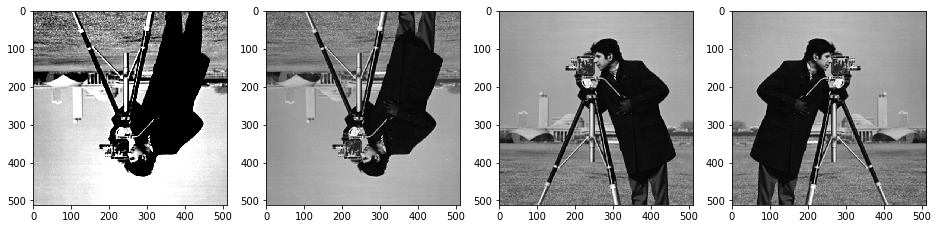

In [5]:
# you can run this line several times to see different outputs
plot_batch(multithreaded_generator.next())

In [6]:
multithreaded_generator._finish() # kill the workers

## Lets add some deformations, scaling and rotations. 
We use very aggressive parameters here to visualize the effects. In your experiment you should choose parameters that make sense in the context of your data.
Not how we are using angle_z here. We are rotating around the (nonexistent) z axis. Always double check whether the rotations are around the correct axis.

In [7]:
from batchgenerators.transforms.spatial_transforms import SpatialTransform

spatial_transform = SpatialTransform(data.camera().shape, np.array(data.camera().shape) // 2, 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.3, 3.), 
                 border_mode_data='nearest', border_cval_data=0, order_data=1,
                 random_crop=False)

my_transforms.append(spatial_transform)
all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)

starting workers


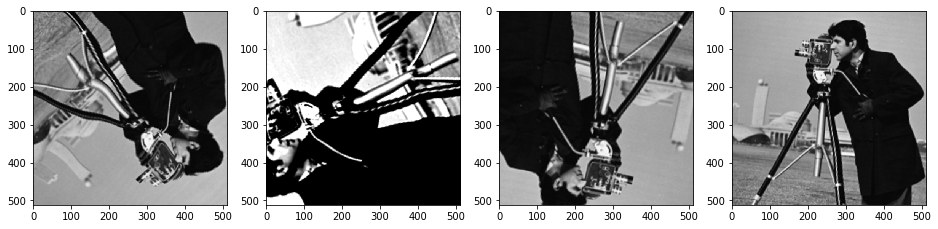

In [8]:
# you can run this line several times to see different outputs. Note how the computation takes long for the 
# first run, but then the batches are returnes very quickly!
plot_batch(multithreaded_generator.next())

## Some timings

In [9]:
# let's do some timing
from time import time

batch_times = []
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)
for _ in range(20):
    start = time()
    _ = multithreaded_generator.next()
    batch_times.append(time() - start)
    print("This batch took %02.3f s" % batch_times[-1])

avg_batch_time_mt = np.mean(batch_times)
print("Multi threaded batch generation using 4 workers took %02.3f s on average per batch" % avg_batch_time_mt)


batch_times = []
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 1, 2, seeds=None)
for _ in range(20):
    start = time()
    _ = multithreaded_generator.next()
    batch_times.append(time() - start)
    print("This batch took %02.3f s" % batch_times[-1])

avg_batch_time_st = np.mean(batch_times)
print("Single threaded batch generation using 4 workers took %02.3f s on average per batch" % avg_batch_time_st)

print("Multi threaded speedup: %02.2f" % (avg_batch_time_st/avg_batch_time_mt))

starting workers
This batch took 1.792 s
This batch took 0.097 s
This batch took 0.095 s
This batch took 0.074 s
This batch took 0.950 s
This batch took 0.104 s
This batch took 0.104 s
This batch took 0.037 s
This batch took 0.579 s
This batch took 0.037 s
This batch took 0.126 s
This batch took 0.095 s
This batch took 1.049 s
This batch took 0.104 s
This batch took 0.086 s
This batch took 0.058 s
This batch took 0.545 s
This batch took 0.018 s
This batch took 0.019 s
This batch took 0.018 s
Multi threaded batch generation using 4 workers took 0.299 s on average per batch
starting workers
This batch took 1.654 s
This batch took 1.118 s
This batch took 0.775 s
This batch took 1.119 s
This batch took 0.850 s
This batch took 1.139 s
This batch took 0.796 s
This batch took 1.219 s
This batch took 0.784 s
This batch took 1.015 s
This batch took 1.034 s
This batch took 1.167 s
This batch took 0.832 s
This batch took 1.130 s
This batch took 0.929 s
This batch took 1.229 s
This batch took 0.87

### Sometimes you don't want to apply a transformation to every batch. We've got you covered:

In [10]:
from batchgenerators.transforms.abstract_transform import RndTransform

sometimes_spatial_transform = RndTransform(spatial_transform, prob=0.5)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([sometimes_spatial_transform]), 4, 2, seeds=None)

starting workers


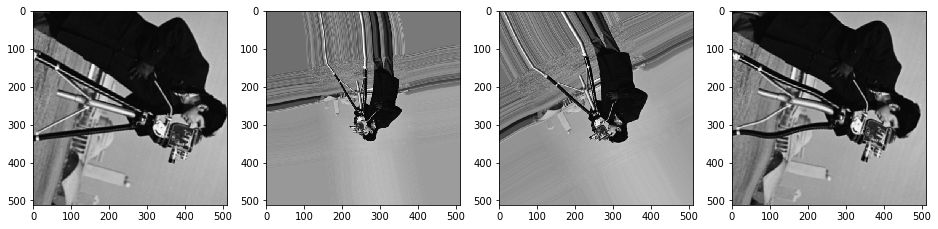

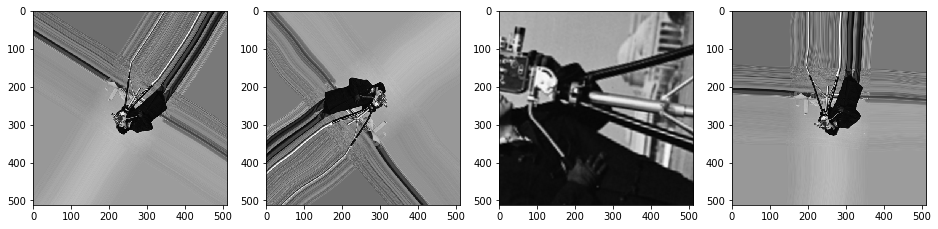

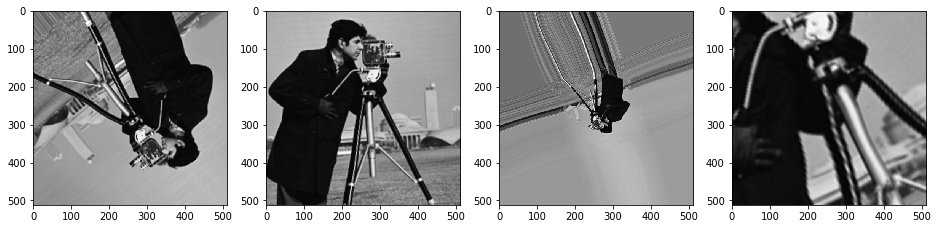

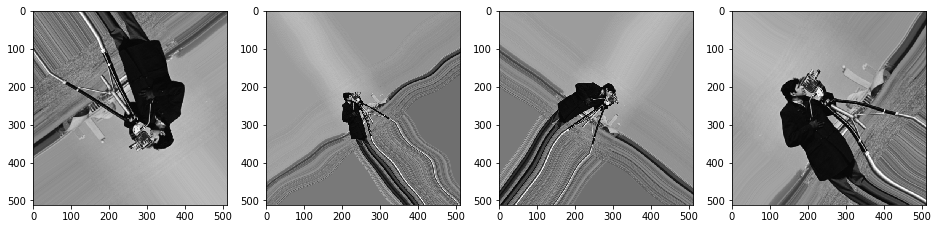

In [11]:
for _ in range(4):
    plot_batch(multithreaded_generator.next())

## Cropping

Usually when you train you need an input patch of a specific size. This is especially true for some segementation problems. If you are NOT using the SpatialTransform then just use the RandomCropTransform or CenterCropTransform. Your DataLoader can in this case return an arbitrarily sized image and you can crontrol the size with those (what is most efficient depends on how your dataset is implemented. I am using numpy memmaps and therefore always return the full size). If you are using SpatialTransform then you can use it to crop your data at the same time they are transformed. “But wait - will transforming a large image not be super slow”? No, because the way SpatialTransform works is that is creates a coordinate grid that is transformed and in the end the data is interpolated along that grid. The computation time therefore depends only on the output patch size. Also, if you have a 128x128 patch that you then transform spatially, you will get border artifacts. If you instead plug the entire image into the SpatialTransform and tell it to extract a 128x128 patch then you can avoid these artifacts!

starting workers
Crop followed by SpatialTransform (20 batches) took: 1.582 s


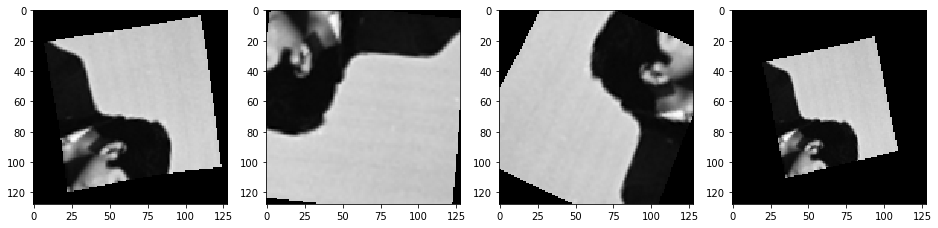




starting workers
Crop integrated into SpatialTransform (20 batches) took: 1.725 s


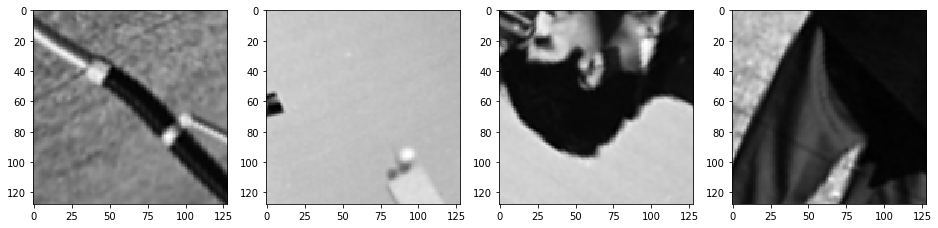

In [12]:
# Spatial augmentation with small patches, crop first then transform (do not do this)
from batchgenerators.transforms.crop_and_pad_transforms import RandomCropTransform
crop_size = (128, 128)

crop = RandomCropTransform(crop_size=crop_size)
spatial_transform = SpatialTransform(crop_size, np.array(crop_size) // 2, 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.5, 2),
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=False)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([crop, spatial_transform]), 4, 2, seeds=None)

# time it
start = time()
for _ in range(100):
    _ = multithreaded_generator.next()
print("Crop followed by SpatialTransform (20 batches) took: %02.3f s" % (time()-start))

plot_batch(multithreaded_generator.next())

print("\n\n")

# spatial augmentation with snall patches, transform and crop together (do this!)
spatial_transform = SpatialTransform(crop_size, np.array(crop_size) // 2,
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),
                 do_scale=True, scale=(0.5, 2),
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=True)
multithreaded_generator = MultiThreadedAugmenter(batchgen, Compose([spatial_transform]), 4, 2, seeds=None)

# time it
start = time()
for _ in range(100):
    _ = multithreaded_generator.next()
print("Crop integrated into SpatialTransform (20 batches) took: %02.3f s" % (time()-start))

plot_batch(multithreaded_generator.next())

As you can see you are much less likely to get border artifacts when using the second option. Output is in each case a batch with size 128x128 pixels and computation time is the same!

### We hope this tutorial helped. For suggestions please contact us ;-)